# Instruction on how to read from the result folder
Author: Yicheng Zhu 2023-11-07
yzhu19@smith.edu

-------------

## Convention

#### <span style="color:red">IMPORTANT</span>

Throughout this experiment, _polar-dominant_ is ```True``` and _cartesian-dominant_ is ```False```

Throughout this experiment, if there is a matrix and contains 10 columns, ```index 0 - 4``` represent the five polar-dominant portions, and ```index 5 - 9``` represent the five cartesian-dominant portions

_________________


## Overview
All the usable data are recorded in the form of numpy arrays.

Because of the lack of labeling of those data, this jupyter notebook will help people easily figure out how to extract the usable data.

#### Import the packages for use

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
#import cv2
#from p2ctransformer.p2c import *
#from model import *
#from data import *
#from defines import *

#### Set the directory of the interested result folder
Note that depending on the migration framework used, it's possible that some data is not available -- for example, there is no 'probability-history' if Cuiling's method or Chris' method is used.

Here set the ```resultdir``` to the address of 'results' folder

In [1]:
resultsdir = '/home/scram-2004/Project/Our-UNet-Code/results'

In [2]:
resultsdir = '/Users/yichengzhu/Documents/GitHub/Our-UNet-Code/results'

In [ ]:
resultsdir = '/home/scram-2004/Project/Our-UNet-Code/history_results/results20231207'

----------------------

## Type of Data stored

### 0. FileMatrix
Filematrix is stored as ```.png``` file and therefore is a little different to load. The purpose of it is to enable a visual sanity check of if only once one image is appeared in. 

This png contains of a 7407 * 10 matrix. Each row represents one image, e.g. first row represents image ```0.tif```. The black dot's location represents the file location.

#### Instruction on how to read filematrix
Well, basically click open and scan through. The location information contained can be found in score-matrix, so there's no need to bother reading this file.

### 1. History
History is a location log that records the coarse location of if the image is considered as polar or cartesian dominant per that round. 

History contains of 7404*(R+1) data, where R is the number of rounds we iterate through

A newer history will contain the older one, so it's always just enough to read the history file names: ```history_round_MAXNUM.npy```


#### Example of reading history location

In [ ]:
history_file = os.path.join(resultsdir,'history/history_round_2.npy')

In [ ]:
history = np.load(history_file)

In [ ]:
history.shape

In [ ]:
history_slice = history[:,-1]

In [ ]:
history_slice.shape

In [ ]:
for i in range(history.shape[1]):
    slice = history[:,i]
    print(np.sum(slice))

### 2. Models History
Model History is the log of loss history when the model was trained. For each iteration, the five polar model histories and the five cartesian model histories are bundled into two seperate files and can be found separately. 

Basically, the most relevant data we can extract from a model history is the loss that it is converged to. Given that we are using the checkpoint to store the model with minimum loss, the last digit of the curve does not necessarily mean the final loss of the one that we finally decided to keep.

In order to extract that, the minimum of each curve should be taken.

#### Example of reading model history

In [ ]:
model_history_file = os.path.join(resultsdir,'models_history/round_2/polar_history.npy')
model_history = np.load(model_history_file)

In [ ]:
model_history.shape

In [ ]:
print(model_history)

In [ ]:

plt.plot(model_history[:][:][:])


In [ ]:
#Getting the min of model loss
for i in range(5):
    current_model = model_history[i][:]
    print(np.min(current_model))

### 3. prob_history

This is only going to appear in Yicheng's random migration framework result so that I will skip this part for now.

### 4. Score Matrix

#### <span style="color:red">IMPORTANT</span>

Score matrix is the main character here and I believe lots of analysis can be done on it. 

The shape of it is always 7404*10. Each row, there are 6 scores and 4 blanks (in the form of 0s). The location tells us which model is this score generated from. 

For example, the score in the second coloumn is always the generated by the polar model which used the portion index 0, 2, 3, 4 as the training set.

#### In-group score vs. out-of-group scores

Given that there are 6 scores, 1 in-group and 5 out-of-group, stored in the matrix, I need to clarify that the one in-group score is what we considered MOST IMPORTANT because ultimately we would like to have a better and better in-group score.

#### Example of reading score matrix:

1. Example for plotting out the in-group score (weighted)

0.04808295024989385
0.09466106140346009
0.08796379634274798
0.19725573405328709
[ 0.         -0.00376518  0.          0.          0.          0.49614746
  0.37344927  0.41190719  0.44923977  0.56246563]
0.0
[ 0.          0.          0.         -0.00182977  0.          0.48634238
  0.30216075  0.45775548  0.32726843  0.49020778]
0.0
0.13085339843735275
0.08399325267918763
0.08732624348168332
0.25428870575988605


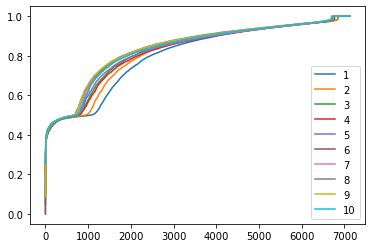

In [3]:
for i_round in range(10):
    x_range = 7404
    scoreMatrix_file = 'scorematrix/scorematrix_round_' + str(i_round) + '.npy'
    scoreMatrix = np.load(os.path.join(resultsdir, scoreMatrix_file))
    model_history_file_polar = os.path.join(resultsdir,'models_history/round_'+ str(i_round) +'/polar_history.npy')
    model_history_file_carte = os.path.join(resultsdir,'models_history/round_'+ str(i_round) +'/carte_history.npy')
    model_history_polar = np.load(model_history_file_polar)
    model_history_carte = np.load(model_history_file_carte)
    model_loss_num = []
    for i in range(5):
        current_model = model_history_polar[i][:]
        model_loss_num.append(np.min(current_model))
    for i in range(5):
        current_model = model_history_carte[i][:]
        model_loss_num.append(np.min(current_model))
    #print(model_loss_num)
    picked_score = np.zeros(scoreMatrix[:,0].shape)
    weighted_score = np.zeros(scoreMatrix[:,0].shape)
    i = 0
    for each_row in scoreMatrix:
        first_zero = np.where(each_row == 0)[0][0]
        if first_zero >= 5:
            chosen = max(each_row[5:])
        else:
            chosen = max(each_row[:5])
        picked_score[i] = chosen
        #print(each_row)
        #print(chosen)
        picked_index = np.where(each_row == chosen)[0][0]
        #print(picked_index)
        picked_loss = model_loss_num[picked_index]
        weighted_score[i] = chosen * (1 - picked_loss)
        i += 1
        if chosen == 0:
            print(each_row)
    print(min(picked_score))
    plt.plot(np.sort(picked_score))
    plt.legend([1,2,3,4,5,6,7,8,9,10])


2. Example for getting a filtered illustration, from the first one, pick out the index that contains the scores below threshold, then ignore all data from that index for the rest rounds.

1062
548
381
322
296
273
257
248
242
239


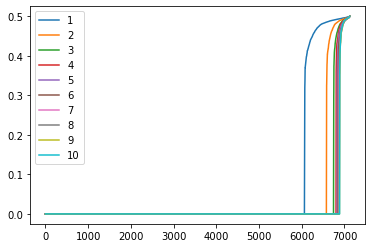

In [6]:
index_below_threshold = []
ifFirstRound = True
check_Threshold = 0.5
for i_round in range(10):
    x_range = 7404
    scoreMatrix_file = 'scorematrix/scorematrix_round_' + str(i_round) + '.npy'
    scoreMatrix = np.load(os.path.join(resultsdir, scoreMatrix_file))
    model_history_file_polar = os.path.join(resultsdir,'models_history/round_'+ str(i_round) +'/polar_history.npy')
    model_history_file_carte = os.path.join(resultsdir,'models_history/round_'+ str(i_round) +'/carte_history.npy')
    model_history_polar = np.load(model_history_file_polar)
    model_history_carte = np.load(model_history_file_carte)
    model_loss_num = []
    for j in range(5):
        current_model = model_history_polar[j][:]
        model_loss_num.append(np.min(current_model))
    for j in range(5):
        current_model = model_history_carte[j][:]
        model_loss_num.append(np.min(current_model))
    #print(model_loss_num)
    picked_score = np.zeros(scoreMatrix[:,0].shape)
    weighted_score = np.zeros(scoreMatrix[:,0].shape)
    i = 0
    for each_row in scoreMatrix:
        first_zero = np.where(each_row == 0)[0][0]
        if first_zero >= 5:
            chosen = max(each_row[5:])
        else:
            chosen = max(each_row[:5])
        
        if ifFirstRound:
            if chosen < check_Threshold:
                picked_score[i] = chosen
                index_below_threshold.append(True)
            else:
                picked_score[i] = 0
                index_below_threshold.append(False)
        else:
            if not index_below_threshold[i]:
                picked_score[i] = 0
            else:
                if chosen > check_Threshold:
                    picked_score[i] = 0
                    index_below_threshold[i] = False
                else:
                    picked_score[i] = chosen
        #print(each_row)
        #print(chosen)
        picked_index = np.where(each_row == chosen)[0][0]
        #print(picked_index)
        picked_loss = model_loss_num[picked_index]
        weighted_score[i] = chosen * (1 - picked_loss)
        i += 1
    ifFirstRound = False
    #print(picked_score)
    plt.plot(np.sort(picked_score))
    plt.legend([1,2,3,4,5,6,7,8,9,10])
    print(np.sum(index_below_threshold))

    

2.1. After getting the index, load other histories to see if those images are consistently BAD regardless of the round


129


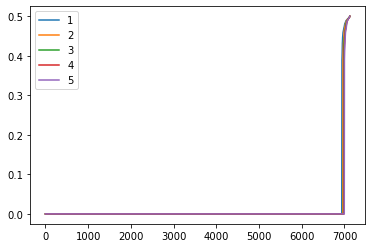

In [5]:
anotherresultdir = 'history_results/results20231202/'

for i in range(5):
    x_range = 7404
    scoreMatrix_file = 'scorematrix/scorematrix_round_' + str(i) + '.npy'
    scoreMatrix = np.load(os.path.join(anotherresultdir, scoreMatrix_file))
    model_history_file_polar = os.path.join(anotherresultdir,'models_history/round_'+ str(i) +'/polar_history.npy')
    model_history_file_carte = os.path.join(anotherresultdir,'models_history/round_'+ str(i) +'/carte_history.npy')
    model_history_polar = np.load(model_history_file_polar)
    model_history_carte = np.load(model_history_file_carte)
    model_loss_num = []
    for i in range(5):
        current_model = model_history_polar[i][:]
        model_loss_num.append(np.min(current_model))
    for i in range(5):
        current_model = model_history_carte[i][:]
        model_loss_num.append(np.min(current_model))
    #print(model_loss_num)
    picked_score = np.zeros(scoreMatrix[:,0].shape)
    weighted_score = np.zeros(scoreMatrix[:,0].shape)
    i = 0
    for each_row in scoreMatrix:
        first_zero = np.where(each_row == 0)[0][0]
        if first_zero >= 5:
            chosen = max(each_row[5:])
        else:
            chosen = max(each_row[:5])
        
        if ifFirstRound:
            if chosen < check_Threshold:
                picked_score[i] = chosen
                index_below_threshold.append(True)
            else:
                picked_score[i] = 0
                index_below_threshold.append(False)
        else:
            if not index_below_threshold[i]:
                picked_score[i] = 0
            else:
                if chosen > check_Threshold:
                    picked_score[i] = 0
                    index_below_threshold[i] = False
                else:
                    picked_score[i] = chosen

        #print(each_row)
        #print(chosen)
        picked_index = np.where(each_row == chosen)[0][0]
        #print(picked_index)
        picked_loss = model_loss_num[picked_index]
        weighted_score[i] = chosen * (1 - picked_loss)
        i += 1
    ifFirstRound = False
    #print(picked_score)
    plt.plot(np.sort(picked_score))
    plt.legend([1,2,3,4,5,6,7,8,9,10])
print(np.sum(index_below_threshold))

In [ ]:
np.save('picked_index.npy',index_below_threshold)

The Following block shows the 10 in-group scores for one specific image

In [ ]:
interested_image = [121]
for i in range(10):
    x_range = 7404
    scoreMatrix_file = 'scorematrix/scorematrix_round_' + str(i) + '.npy'
    scoreMatrix = np.load(os.path.join(resultsdir, scoreMatrix_file))
    picked_score = np.zeros(scoreMatrix[:,0].shape)
    i = 0
    for this_row_index in interested_image:
        this_row = scoreMatrix[this_row_index]
        first_zero = np.where(this_row == 0)[0][0]
        if first_zero >= 5:
            chosen = max(this_row[5:])
        else:
            chosen = max(this_row[:5])
        picked_score[i] = chosen
        picked_index = np.where(this_row == chosen)[0][0]
        picked_loss = model_loss_num[picked_index]
        weighted_score[i] = chosen * (1 - picked_loss)
        i += 1
        if chosen == 0:
            print(this_row)

In [ ]:
print(np.sum(index_below_threshold))
print(np.size(index_below_threshold))
for i in range(np.size(index_below_threshold)):
    if index_below_threshold[i]:
        print(i)

3. Example for plotting the difference of difference of, for each image, the maximum score it got and the average

PS> I know you can do better than my hard-coded method

In [ ]:
scoreMatrix_0 = np.load(os.path.join(resultsdir, ('scorematrix/scorematrix_round_0.npy')))
scoreMatrix_1 = np.load(os.path.join(resultsdir, ('scorematrix/scorematrix_round_1.npy')))
scoreMatrix_2 = np.load(os.path.join(resultsdir, ('scorematrix/scorematrix_round_2.npy')))
scoreMatrix_3 = np.load(os.path.join(resultsdir, ('scorematrix/scorematrix_round_3.npy')))

dif = []
for i in range(scoreMatrix.shape[0]):
    fst = np.max(scoreMatrix_0[i]).item(0)
    snd = np.max(scoreMatrix_1[i]).item(0)
    trd = np.max(scoreMatrix_2[i]).item(0)
    fth = np.max(scoreMatrix_3[i]).item(0)
    #print(fst,snd,trd,fth)
    max_f = max(fst,snd,trd,fth)
    avg = (fst+snd+trd+fth)/4
    dif.append(max_f - avg)
    
dif_np = np.asarray(dif)
plt.plot(np.sort(dif_np))

### This following method is used to pick the interested round and see how many of them are moving around in our method

[91, 76, 66, 31, 26, 19, 43, 10, 20, 11]
[405, 420, 308, 209, 207, 99, 144, 129, 166, 100]


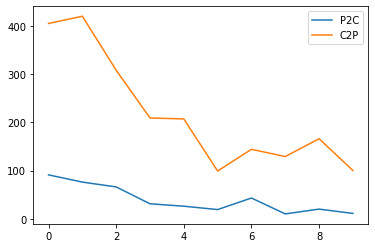

In [7]:
ch_plot = []
ph_plot = []
for interested_round in range(10):
    scoreMatrix_file = 'scorematrix/scorematrix_round_' + str(interested_round) + '.npy'
    history_file_path= 'history/history_round_' + str(interested_round) + '.npy'
    history_file = os.path.join(resultsdir,history_file_path)
    history = np.load(history_file)
    scorematrix = np.load(os.path.join(resultsdir, scoreMatrix_file))
    history_slice = history[:,interested_round]
    diff = np.zeros(7126)
    Transition_threshold = 0.3
    ch = 0
    ph = 0
    for i in range(7126):
        if history_slice[i]:
            polar_score = np.max(scorematrix[i][:5])
            carte_score = np.median(scorematrix[i][5:])
            #print(carte_score,polar_score)
            if carte_score > polar_score:
                #print('Carte-higher')
                dif = polar_score - carte_score
                if abs(dif) > Transition_threshold:
                    ch += 1
                    #print(scorematrix[i])
                    diff[i] = dif
                #decision[i] = 1
        else:
            polar_score = np.median(scorematrix[i][:5])
            carte_score = np.max(scorematrix[i][5:])
            #print(carte_score,polar_score)
            if carte_score < polar_score:
                #print('Polar-higer')
                dif = polar_score - carte_score
                if abs(dif) > Transition_threshold:
                    ph += 1
                    #print(scorematrix[i])
                    diff[i] = dif
                    #decision[i] = -1
        
    #print(ch, ph)
    ch_plot.append(ch)
    ph_plot.append(ph)

plt.plot(ch_plot)
plt.plot(ph_plot)
print(ch_plot)
print(ph_plot)
plt.legend(['P2C','C2P'])

### This following chunk checks the predicted 956 images. This is only available for results generated after Nov.13 2023

In [ ]:
def dice_coefficient_carte(image1, image2):#Generate the Dice coefficient of two binary images, should do thresholding before inputting
    # Ensure the input images have the same shape
    smooth = 1
    if image1.shape != image2.shape:
        raise ValueError("Input images must have the same shape.")
    image1 = np.matrix(image1)
    image2 = np.matrix(image2)
    img1_f = (~image1.astype(bool)).astype(int)
    img2_f = (~image2.astype(bool)).astype(int)
    # Calculate the intersection (logical AND) between the two binary images
    intersection_o = np.logical_and(image1, image2).sum()
    intersection_f = np.logical_and(img1_f, img2_f).sum()
    #print(intersection_o,intersection_f)
    # Calculate the sum of pixels in each image
    sum_image1_o = image1.sum()
    sum_image2_o = image2.sum()
    #print(sum_image1_o,sum_image2_o)
    sum_image1_f = img1_f.sum()
    sum_image2_f = img2_f.sum()
    #print(sum_image1_f,sum_image2_f)
   
    # Calculate the Dice coefficient
    dice = (2.0 * intersection_o + smooth) / (sum_image1_o + sum_image2_o + smooth)
    #print('dice',dice)
    dice_f = (2.0 * (intersection_f - 14616) + smooth) / (sum_image1_f + sum_image2_f + smooth - 29232) #Hard-coded numbers here, need to prove 
    #print('dice_f',dice_f)
    dice_avg = (dice + dice_f) / 2.0
    #print('dice_avg', dice_avg)
    return dice_avg

In [ ]:
polar_prediction_file = 'polar_prediction.npy'
carte_prediction_file = 'carte_prediction.npy'
polar_prediction = np.load(os.path.join(resultsdir,polar_prediction_file))
carte_prediction = np.load(os.path.join(resultsdir,carte_prediction_file))
test_label_folder_path = 'data/endoscopic_test956/cartesian/label'
count = 0
trans_dic = p2c_dic_gen(127, 127, 256, 256)
polar_dice = []
carte_dice = []
for prediction in [polar_prediction,carte_prediction]:
    for i in range(956):
        test_file_name = os.path.join(test_label_folder_path, (str(i) + '.tif'))
        ground_truth_mask = cv2.imread(test_file_name, cv2.IMREAD_GRAYSCALE)
        ground_truth_mask = ground_truth_mask / 255.0
        ground_truth_mask = ground_truth_mask.astype(np.uint8)
        current_prediction = prediction[i]
        current_prediction = np.reshape(current_prediction,(256,256))
        threshold = 0.5
        current_prediction = (current_prediction > threshold).astype(np.uint8)
        if count == 0:
            current_prediction = p2c(current_prediction, trans_dic)
            polar_dice.append(dice_coefficient_carte(ground_truth_mask,current_prediction))
        else:
            carte_dice.append(dice_coefficient_carte(ground_truth_mask,current_prediction))
            
        
    count += 1
polar_dice = np.asarray(polar_dice)
carte_dice = np.asarray(carte_dice)

In [ ]:
polar_past_score_file = 'prev-analysis/analysis_dice_back_Test_P2C.npy'

polar_past_score = np.load(polar_past_score_file)

polar_performance_inc = polar_dice - polar_past_score
plt.plot(np.sort(polar_dice))
plt.plot(np.sort(polar_past_score))
plt.plot(np.sort(polar_performance_inc))
plt.legend(['new','past','dif'])

In [ ]:
carte_past_score_file = 'prev-analysis/analysis_dice_back_Test_C.npy'
carte_past_score = np.load(carte_past_score_file)
carte_performance_inc = carte_dice - carte_past_score
plt.plot(np.sort(carte_dice))
plt.plot(np.sort(carte_past_score))
plt.plot(np.sort(carte_performance_inc))

plt.legend(['new','past','dif'])

### In order to have a fair comparison, a model shall be trained using the same machine to be the baseline of comparison.

In [ ]:
cartesian_original_folder = 'data/endoscopic/cartesian'
polar_original_folder = 'data/endoscopic/polar'
batch_size = 5
carte_data_gen_args = dict(rotation_range = 80,      # TODO: improve the data augmentation
                width_shift_range =0.02,
                height_shift_range =0.02,
                shear_range = 0.35,
                zoom_range = 0.075,
                horizontal_flip = True,
                fill_mode = 'nearest',
                rescale = 1./255)
bt_carte_generator = trainGenerator(batch_size, cartesian_original_folder, PARAM_IMG_FOLDER, PARAM_MSK_FOLDER, carte_data_gen_args)
big_model_carte = unet(PARAM_BETA1[PARAM_BETA_TEST_NUM], PARAM_BETA2[PARAM_BETA_TEST_NUM])
big_model_carte_checkpoint = ModelCheckpoint('./big_model_carte.hdf5',monitor = 'loss', verbose = 1, save_best_only=True)
big_model_carte.fit(bt_carte_generator, verbose = 1, steps_per_epoch = STEPS, epochs = EPOCHS, callbacks = [big_model_carte_checkpoint])
big_carte_test_gene = testGenerator('./data/endoscopic_test956/cartesian', PARAM_IMG_FOLDER, PARAM_MSK_FOLDER)
big_carte_results = big_model_carte.predict_generator(big_carte_test_gene, 956, verbose=1)
np.save('./big_carte_prediction.npy', big_carte_results)
polar_data_gen_args = dict(rotation_range = 50,      # TODO: improve the data augmentation
            width_shift_range =0.2,
            height_shift_range =0.2,
            shear_range = 0.35,
            zoom_range = 0.05,
            horizontal_flip = True,
            fill_mode = 'nearest',
            rescale = 1./255)
bt_polar_generator = trainGenerator(batch_size, polar_original_folder, PARAM_IMG_FOLDER, PARAM_MSK_FOLDER, polar_data_gen_args)
big_model_polar = unet(PARAM_BETA1[PARAM_BETA_TEST_NUM], PARAM_BETA2[PARAM_BETA_TEST_NUM])
big_model_polar_checkpoint = ModelCheckpoint('./big_model_polar.hdf5',monitor = 'loss', verbose = 1, save_best_only=True)
big_model_polar.fit(bt_polar_generator, verbose = 1, steps_per_epoch = STEPS, epochs = EPOCHS, callbacks = [big_model_polar_checkpoint])
big_polar_test_gene = testGenerator('./data/endoscopic_test956/polar', PARAM_IMG_FOLDER, PARAM_MSK_FOLDER)
big_polar_results = big_model_polar.predict_generator(big_polar_test_gene, 956, verbose=1)
np.save('./big_polar_prediction.npy', big_polar_results)

In [ ]:
polar_prediction_file = 'big_polar_prediction.npy'
carte_prediction_file = 'big_carte_prediction.npy'
polar_prediction = np.load(polar_prediction_file)
carte_prediction = np.load(carte_prediction_file)
test_label_folder_path = 'data/endoscopic_test956/cartesian/label'
count = 0
big_polar_dice = []
big_carte_dice = []
for prediction in [polar_prediction,carte_prediction]:
    for i in range(956):
        test_file_name = os.path.join(test_label_folder_path, (str(i) + '.tif'))
        ground_truth_mask = cv2.imread(test_file_name, cv2.IMREAD_GRAYSCALE)
        ground_truth_mask = ground_truth_mask / 255.0
        ground_truth_mask = ground_truth_mask.astype(np.uint8)
        current_prediction = prediction[i]
        current_prediction = np.reshape(current_prediction,(256,256))
        threshold = 0.5
        current_prediction = (current_prediction > threshold).astype(np.uint8)
        if count == 0:
            current_prediction = p2c(current_prediction, trans_dic)
            big_polar_dice.append(dice_coefficient_carte(ground_truth_mask,current_prediction))
        else:
            big_carte_dice.append(dice_coefficient_carte(ground_truth_mask,current_prediction))
            
        
    count += 1
big_polar_dice = np.asarray(big_polar_dice)
big_carte_dice = np.asarray(big_carte_dice)

In [11]:
polar_big_score = np.load('polar_overall.npy')
polar_dice = np.load('polar_new_pre.npy')
polar_performance_inc = polar_dice - polar_big_score
plt.plot(np.sort(polar_dice))
plt.plot(np.sort(polar_big_score))
plt.plot(np.sort(polar_performance_inc))
plt.legend(['new','past','dif'])

ValueError: operands could not be broadcast together with shapes (2868,) (956,) 

In [10]:
carte_big_score = np.load('big_carte_prediction_score.npy')

carte_performance_inc = carte_dice - carte_big_score
plt.plot(np.sort(carte_dice))
plt.plot(np.sort(carte_big_score))
plt.plot(np.sort(carte_performance_inc))
plt.legend(['new','past','dif'])

NameError: name 'carte_dice' is not defined